In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def CryptoData(symbol, frequency):
    #Parameters: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start=0'
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df

In [7]:
df = CryptoData(symbol = 'BTC_XRP', frequency = 300)
#When frequency = 300, data is refreshed every 5 minutes

We are interested developing a simple moving average (SMA) crossover strategy for trading Bitcoin and Ripple. A crossover is a relatively basic trading strategy that identifies shifts in price momentum that can be used as buy or sell signals. Our crossover strategy will consisit of a leading SMA and a lagging SMA. Leading SMA or the "short-term average" has less periods when calculating the average, so it is more sensitive to recent price changes. Lagging SMA or the "long-term average" has more periods, so it is less sensitive to recent price changes.

Text(0,0.5,'Price')

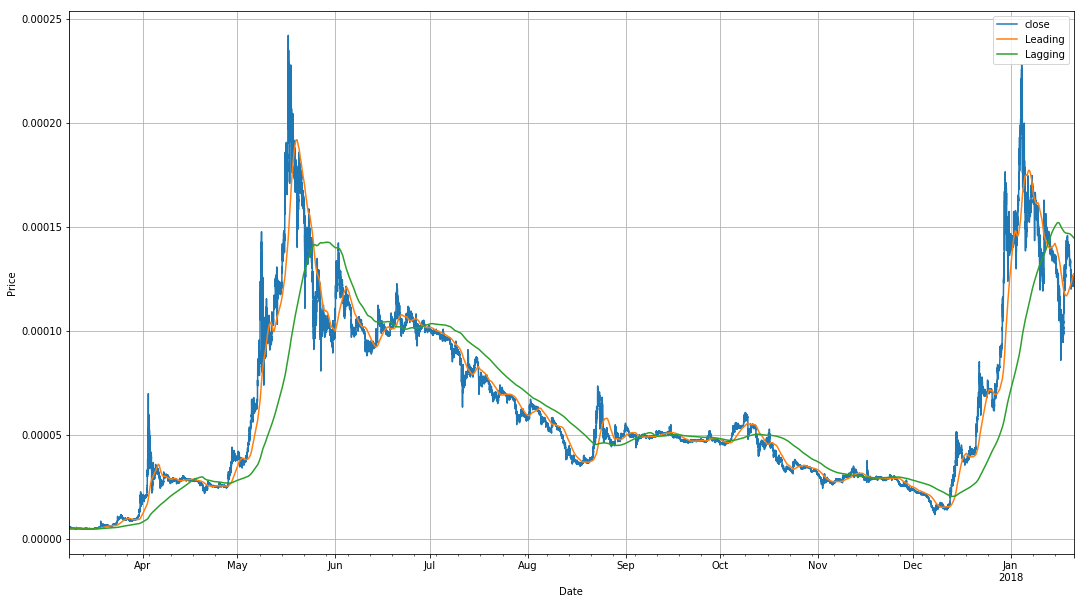

In [54]:
df['Leading'] = df['close'].rolling(1000).mean()
df['Lagging'] = df['close'].rolling(5000).mean()
df[['close','Leading','Lagging']][270000:].plot(figsize = (18,10), grid = True)
plt.xlabel('Date')
plt.ylabel('Price')

Trading Strategy: 
1. BUY if Leading SMA is ABOVE Lagging SMA by a certain threshold
2. SELL if Leading SMA is BELOW Lagging Simple Moving Avg. by a certain threshold

In [5]:
def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()
    ma_df['lead'] = ma_df['close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['close'].rolling(lag).mean()
    ma_df.dropna(inplace = True)
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['close']
    ma_df['regime'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['regime'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['regime'])
    ma_df['Market'] = np.log(ma_df['close'] / ma_df['close'].shift(1))
    ma_df['Strategy'] = ma_df['regime'].shift(1) * ma_df['Market']
    ma_df[['Market','Strategy']] = ma_df[['Market','Strategy']].cumsum().apply(np.exp)
    return ma_df

The 'regime' column dictates the buying and selling logic. When the value changes to 1, we buy, and then we don't sell until it changes to -1. A 0 would mean we have no position and wait until the next buy or sell signal. The 'Market' column is the log returns of the change in price between BTC and XRP. The 'Strategy' column is our returns when using the SMA crossover strategy. It is computed by multipling 'regime' (shifted forward to match the 'Market' column) by 'Market'

In [45]:
ma_df = test_ma(df, 1000, 5000).dropna()
ma_df.tail()

,close,high,low,open,quoteVolume,volume,weightedAverage,Leading,Lagging,lead,lag,lead-lag,pc_diff,regime,Market,Strategy
date,,,,,,,,,,,,,,,,
2018-01-20 23:25:00,0.000123,0.000123,0.000122,0.000123,24831.627121,3.043516,0.000123,0.000128,0.000145,0.000128,0.000145,-0.000017,-0.142219,-1,14.412941,879.386481
2018-01-20 23:30:00,0.000123,0.000123,0.000122,0.000122,26114.769668,3.203665,0.000123,0.000128,0.000145,0.000128,0.000145,-0.000017,-0.141430,-1,14.468235,876.025678
2018-01-20 23:35:00,0.000124,0.000124,0.000123,0.000123,167635.163154,20.706707,0.000124,0.000128,0.000145,0.000128,0.000145,-0.000017,-0.140037,-1,14.585882,868.959815
2018-01-20 23:40:00,0.000124,0.000124,0.000123,0.000124,360274.796130,44.602175,0.000124,0.000128,0.000145,0.000128,0.000145,-0.000017,-0.139960,-1,14.567059,870.082683
2018-01-20 23:45:00,0.000123,0.000124,0.000123,0.000124,139207.262918,17.242391,0.000124,0.000128,0.000145,0.000128,0.000145,-0.000017,-0.140068,-1,14.529412,872.337148


In [14]:
ma_df[['Market','Strategy']].iloc[-1]

#Would have outperformed the market by a factor of about 46

Market       14.562353
Strategy    870.363854
Name: 2018-01-20 23:45:00, dtype: float64

Text(0,0.5,'BTC_XRP Return')

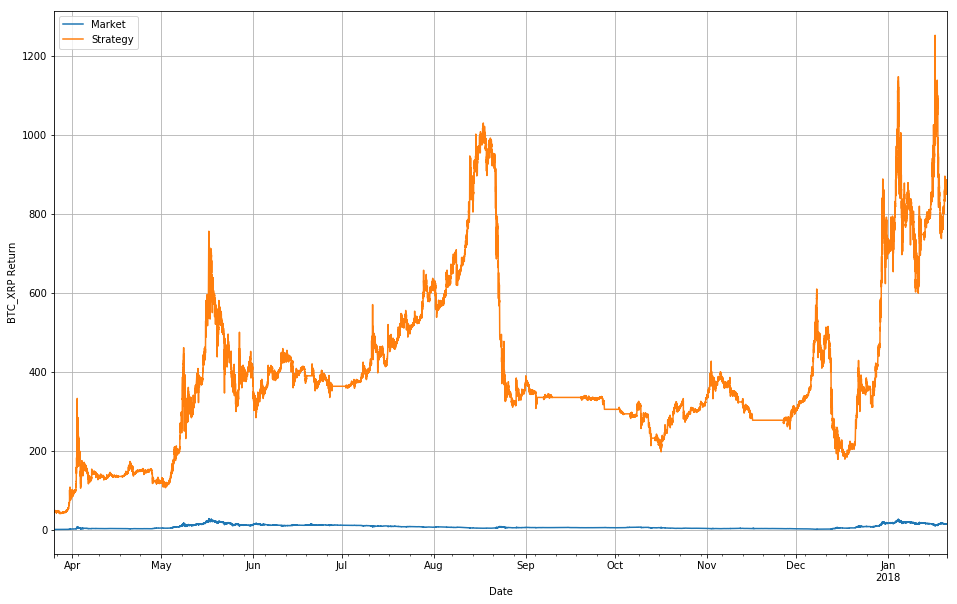

In [49]:
ma_df[['Market','Strategy']][270000:].plot(figsize = (16,10), grid = True)
plt.xlabel('Date')
plt.ylabel('BTC_XRP Return')

We can improve on the lead and lag moving average strategy by finding the combination of values that yields the highest return or profit and loss (PnL). We can create an array of lead and lag pairs and then create a heatmap to indentify the best pairs.

In [16]:
leads = np.arange(100, 4100, 100)
lags = np.arange(4100, 8100, 100)
lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)

In [17]:
for lead, lag in lead_lags:
    pnls[lead][lag] = test_ma(df, lead, lag)['Strategy'][-1]
    print(lead,lag,pnls[lead][lag])

100 4100 2.28704093683
100 4200 3.07878857879
100 4300 2.35272182895
100 4400 4.57753819296
100 4500 5.53637303731
100 4600 7.37384739777
100 4700 4.8951232477
100 4800 5.71991960126
100 4900 5.43372316369
100 5000 3.42152686767
100 5100 5.12548317369
100 5200 6.03607992614
100 5300 4.38755955854
100 5400 3.94599968208
100 5500 3.28434036902
100 5600 2.9399855126
100 5700 2.17105879178
100 5800 2.78396883312
100 5900 2.55716112681
100 6000 3.24814592436
100 6100 3.13666403343
100 6200 3.37058077022
100 6300 2.39230017426
100 6400 1.61031709943
100 6500 2.18123117305
100 6600 2.61337946367
100 6700 1.36231400131
100 6800 0.934046979919
100 6900 0.79131744503
100 7000 1.02940858257
100 7100 0.665544961914
100 7200 1.05870865094
100 7300 1.27274127958
100 7400 1.33026016287
100 7500 0.937032922268
100 7600 1.0206624285
100 7700 1.22934934223
100 7800 1.2526599359
100 7900 0.772963270456
100 8000 0.934062104895
200 4100 19.2497524378
200 4200 22.8742611756
200 4300 19.6971539561
200 4400 1

900 8000 45.5203035586
1000 4100 2021.8687959
1000 4200 1721.76556324
1000 4300 1345.12660065
1000 4400 1778.66871741
1000 4500 1501.19501448
1000 4600 1289.30016426
1000 4700 1086.06836737
1000 4800 829.700811611
1000 4900 657.92992266
1000 5000 872.337148359
1000 5100 721.201499607
1000 5200 886.928480301
1000 5300 946.957355822
1000 5400 834.108020178
1000 5500 733.824084708
1000 5600 572.671447153
1000 5700 376.443755044
1000 5800 577.864541864
1000 5900 426.264654916
1000 6000 338.111860314
1000 6100 319.23782169
1000 6200 249.623182291
1000 6300 256.279885061
1000 6400 207.526096448
1000 6500 248.477153454
1000 6600 119.268826716
1000 6700 69.686086697
1000 6800 85.0844502207
1000 6900 111.084088104
1000 7000 101.153340532
1000 7100 101.995018344
1000 7200 144.012820962
1000 7300 83.0504207296
1000 7400 65.3033790369
1000 7500 40.1129663839
1000 7600 35.8979483403
1000 7700 31.3990702477
1000 7800 43.2119425819
1000 7900 46.0941962295
1000 8000 43.9243797444
1100 4100 1555.571150

1800 6400 47.316384789
1800 6500 65.9323682412
1800 6600 44.8730382647
1800 6700 56.8181481776
1800 6800 33.4661076961
1800 6900 48.8010868112
1800 7000 36.8806276521
1800 7100 41.0683600758
1800 7200 42.0011395739
1800 7300 65.6992037301
1800 7400 38.0779373649
1800 7500 50.8490769988
1800 7600 41.7738558235
1800 7700 48.7977577111
1800 7800 74.8148171064
1800 7900 72.3127470834
1800 8000 70.8292207183
1900 4100 49.1464965956
1900 4200 40.305141302
1900 4300 73.8447511343
1900 4400 111.888600105
1900 4500 346.089702554
1900 4600 135.879604686
1900 4700 186.572510905
1900 4800 204.714235542
1900 4900 286.867337321
1900 5000 250.226345198
1900 5100 232.181661695
1900 5200 169.596551872
1900 5300 158.383085891
1900 5400 121.805992402
1900 5500 106.435315744
1900 5600 63.5798656196
1900 5700 58.5229771437
1900 5800 104.169371168
1900 5900 57.0265448606
1900 6000 65.6473684476
1900 6100 36.1020851713
1900 6200 69.3053826073
1900 6300 81.38508231
1900 6400 61.6695004335
1900 6500 40.0986113

2700 4700 145.584027903
2700 4800 243.647136742
2700 4900 223.59977918
2700 5000 163.882013135
2700 5100 100.285007014
2700 5200 106.743537257
2700 5300 95.2432040064
2700 5400 66.688918149
2700 5500 108.143214294
2700 5600 67.5831097436
2700 5700 58.1722461584
2700 5800 61.952062046
2700 5900 60.461395798
2700 6000 49.2699579113
2700 6100 56.6255375064
2700 6200 38.1788124065
2700 6300 55.4951582419
2700 6400 54.6467050378
2700 6500 39.1947891165
2700 6600 70.8572849977
2700 6700 102.494310952
2700 6800 71.6618661062
2700 6900 42.8481984225
2700 7000 40.2834584825
2700 7100 56.7331848223
2700 7200 43.5844110741
2700 7300 46.493469743
2700 7400 60.5602529184
2700 7500 42.6240664485
2700 7600 77.0350109523
2700 7700 95.8513337474
2700 7800 94.2420039519
2700 7900 77.2559369452
2700 8000 78.7554148881
2800 4100 341.563448078
2800 4200 51.2328847075
2800 4300 89.2297555826
2800 4400 50.3873263935
2800 4500 143.564689685
2800 4600 106.267241022
2800 4700 81.9147430923
2800 4800 143.9855894

3500 7100 100.92989476
3500 7200 62.7978816482
3500 7300 65.1720362445
3500 7400 100.807110969
3500 7500 51.5147819493
3500 7600 50.3870036271
3500 7700 65.4884894977
3500 7800 63.8243820729
3500 7900 84.8355588858
3500 8000 76.4537763568
3600 4100 15.6985009591
3600 4200 106.873419668
3600 4300 140.00538382
3600 4400 1535.65715609
3600 4500 658.099183107
3600 4600 915.036083509
3600 4700 649.811864322
3600 4800 492.996450775
3600 4900 939.451112735
3600 5000 1621.5042906
3600 5100 693.063223937
3600 5200 1111.20955622
3600 5300 256.560305562
3600 5400 470.900730177
3600 5500 339.236376091
3600 5600 171.361827234
3600 5700 415.713044553
3600 5800 696.291543096
3600 5900 169.564517492
3600 6000 180.183905803
3600 6100 167.979434193
3600 6200 184.756780812
3600 6300 221.455933217
3600 6400 171.217433222
3600 6500 147.714669244
3600 6600 104.828529126
3600 6700 63.2751363865
3600 6800 79.2319983492
3600 6900 130.116791207
3600 7000 114.081765157
3600 7100 133.401402952
3600 7200 111.67723

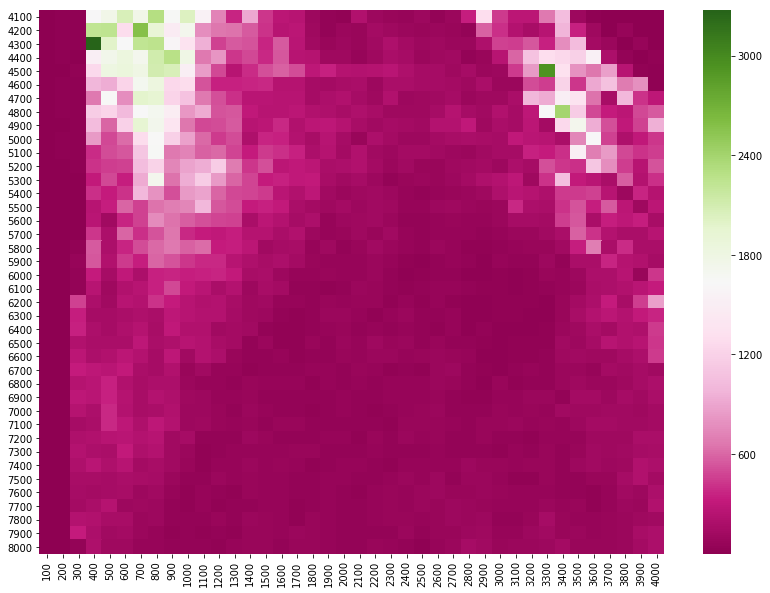

In [19]:
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (14,10))
sns.heatmap(PNLs,cmap= 'PiYG')

In [20]:
PNLs.max()

100        7.373847
200       22.874261
300      469.083245
400     3275.100281
500     2242.432250
600     2062.100524
700     2576.226911
800     2306.636633
900     2279.989386
1000    2021.868796
1100    1555.571151
1200    1153.046843
1300     686.861522
1400     911.021181
1500     517.937410
1600     582.589843
1700     502.390579
1800     307.699530
1900     346.089703
2000     243.485201
2100     220.630666
2200     237.727208
2300     266.616924
2400     199.981377
2500     153.911417
2600     225.759400
2700     243.647137
2800     341.563448
2900    1302.084636
3000     471.558468
3100     591.146561
3200    1086.801818
3300    2938.564586
3400    2396.907988
3500    1720.364427
3600    1621.504291
3700    1066.570687
3800    1001.334034
3900     789.800533
4000     948.796314
dtype: float64

A lead of 400 periods and lag of 4300 periods produces the max PnL.

Text(0,0.5,'Price')

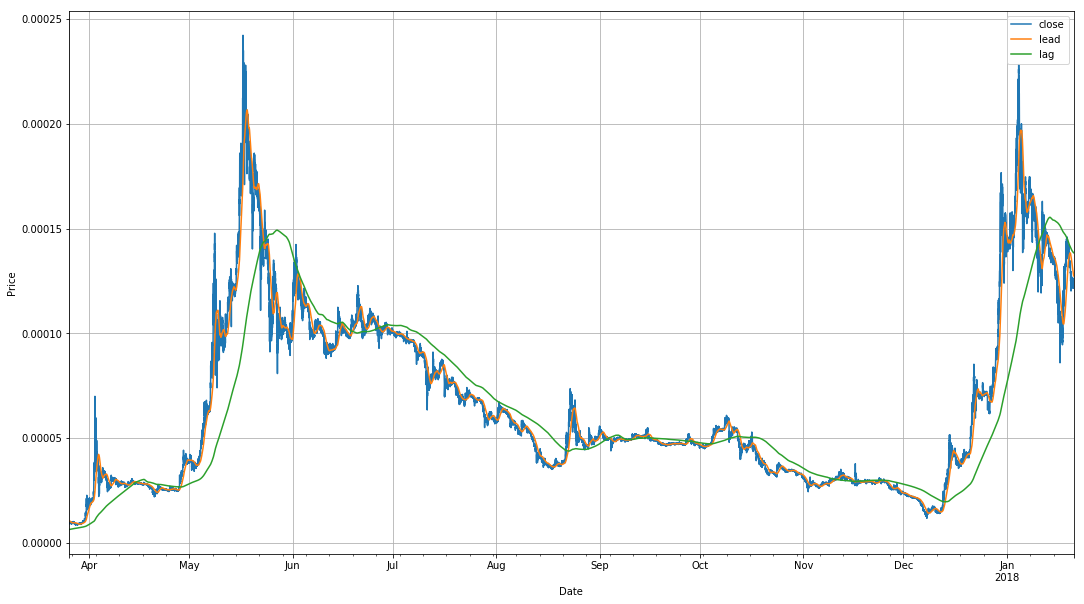

In [47]:
optimal_ma_df = test_ma(df, 400, 4300).dropna()
optimal_ma_df[['close','lead','lag']][270000:].plot(figsize = (18,10), grid = True)
plt.xlabel('Date')
plt.ylabel('Price')

Text(0,0.5,'BTC_XRP Return')

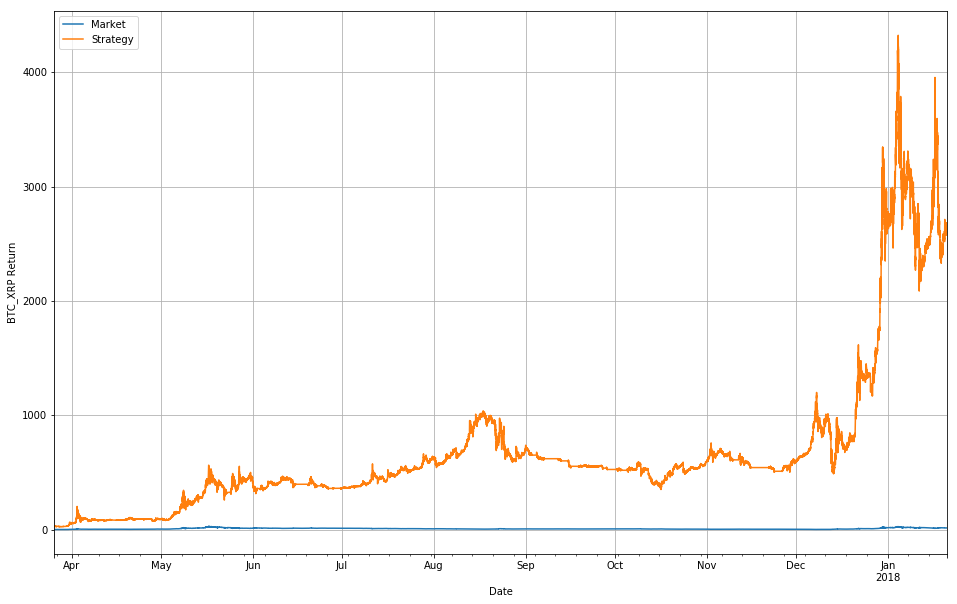

In [50]:
optimal_ma_df[['Market','Strategy']][270000:].plot(figsize = (16,10), grid = True)
plt.xlabel('Date')
plt.ylabel('BTC_XRP Return')

The next step would be to code an algorithmic trading bot that implements this strategy and interacts with an exchange's API.